In [4]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [5]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
torch.cuda.current_device()
# torch.cuda.is_available()
# torch.cuda.device_count()

The code will run on GPU.


0

We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [6]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/zhome/25/e/155273/Desktop/02516_dvcv/02516_intro_cnn/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
size = 128

# Augmented training transformations
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),      # Randomly rotate the images by 10 degrees
    transforms.RandomCrop(size, padding=10),  # Randomly crop a portion of the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor()
])

# Test transformations (without data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

batch_size = 64

# Load the augmented training dataset
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
 

print(len(trainset))
spl= int(len(trainset)/3)

trainset, val_dataset = random_split(trainset, (len(trainset)-spl, spl))
print('TRAIN video number: {}, VAL video number: {}.'.format(len(trainset), len(val_dataset)))
 


train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=3)

# Load the test dataset (without augmentation)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

foo, _ = next(iter(test_loader))
# print(foo.unsqueeze(1))

# print(target.unsqueeze(1))

2047
TRAIN video number: 1365, VAL video number: 682.


Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

Let's look at some images from our data 

torch.Size([64, 3, 128, 128])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.6980, 0.6863, 0.4392],
          [0.0000, 0.0000, 0.0000,  ..., 0.7098, 0.6745, 0.6314],
          [0.0000, 0.0000, 0.0000,  ..., 0.6980, 0.6784, 0.6824],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.7922, 0.7882, 0.4706],
          [0.0000, 0.0000, 0.0000,  ..., 0.7569, 0.7647, 0.7020],
          [0.0000, 0.0000, 0.0000,  ..., 0.7020, 0.7137, 0.7882],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2745, 0.2196, 0.0941],
          [0.0000, 0.0000, 0.0000,  ..., 0.4510, 0.3059, 0.1647],
          [0

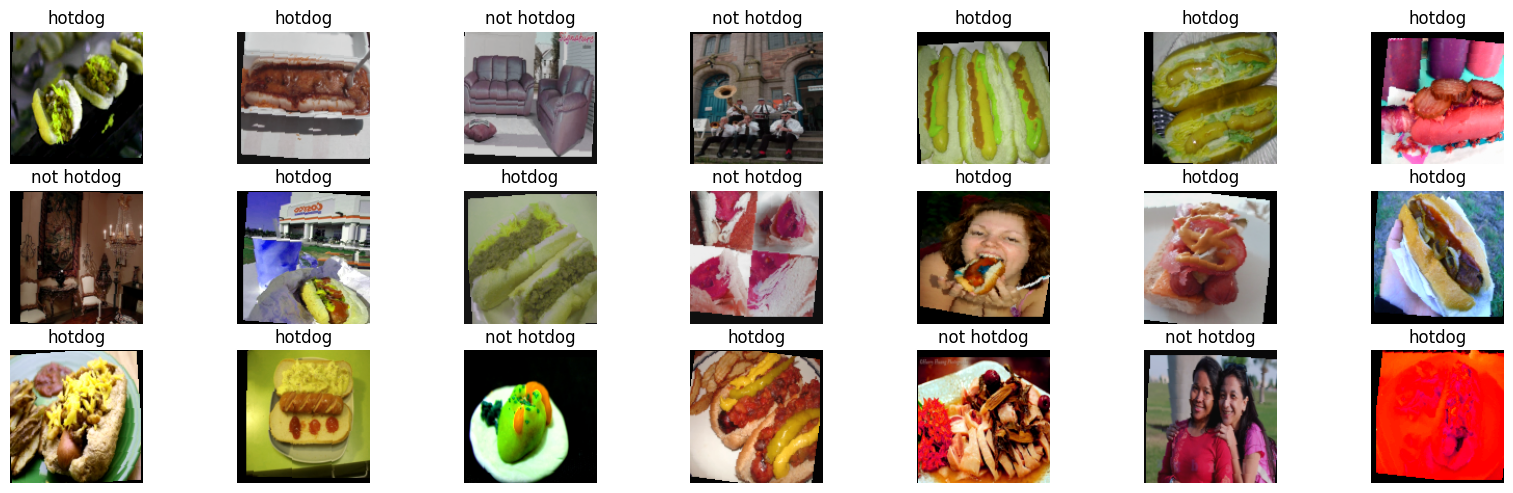

In [8]:
images, labels = next(iter(train_loader))
print(images.shape) #(64,3,128,128) ? 
print(images)
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Now create a model and train it!


In [10]:
class Network02(nn.Module):
    def __init__(self):
        super(Network02, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 2**3, kernel_size=3, padding=0), #127
                nn.ReLU(),
                # nn.MaxPool2d(2, stride=2), #127/2 = 63
                nn.Conv2d(2**3, 2**4, kernel_size=3, padding=0), # 126
                nn.BatchNorm2d(2**4), #should return 62 ?? 
                nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*124*124, 124*124),
                nn.ReLU(),
                nn.Linear(124*124, 500),
                nn.ReLU(),
                nn.Linear(500, 250),
                nn.ReLU(),
                nn.Linear(250, 125),
                nn.ReLU(),
                nn.Linear(125, 1)
        )
        # self.sigmoid = 
    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        # x = nn.F.sigmoid(x)
        # x = nn.Softmax(dim=1)(x)
        return x

In [11]:
class Network03(nn.Module):
    def __init__(self):
        super(Network03, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 2**3, kernel_size=3, padding=0), #start with a resolution of 128, after conv, 126
                nn.Conv2d(2**3, 2**4, kernel_size=3, padding=0), # 126 input, output 124,
                #nn.ReLU()
                nn.MaxPool2d(2, stride=2), #max pool, leaves 62 
                nn.BatchNorm2d(2**4), 
                nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*62*62, 124*124),
                nn.ReLU(),
                nn.Linear(124*124, 500),
                nn.ReLU(),
                nn.Linear(500, 250),
                nn.ReLU(),
                nn.Linear(250, 125),
                nn.ReLU(),
                nn.Linear(125, 1)
        )
        # self.sigmoid = 
    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        # x = nn.F.sigmoid(x)
        # x = nn.Softmax(dim=1)(x)
        return torch.sigmoid(x)

In [12]:
class Network04(nn.Module):
    def __init__(self):
        super(Network04, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.fully_connected = nn.Sequential(
            nn.Linear(in_features=128 * 61 * 61, out_features=512), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)  
        x = self.fully_connected(x)
        return x



In [13]:
model = Network04()
model.to(device)
#Initialize the optimizer
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)

#Get the first minibatc
data = next(iter(train_loader))[0].cuda()
print(data.shape)
# Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit
print("model works with one minibatch")

torch.Size([64, 3, 128, 128])
Shape of the output from the convolutional part torch.Size([64, 128, 61, 61])
model works with one minibatch


In [14]:
# Martins old evaluation loop commented out at 4/1-24 15:38 when Fatema showed better erformance
# import torch.optim as optim

# optimizer = optimizer_adam
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)
 

# num_epochs = 5
# loss_function = nn.BCEWithLogitsLoss()

# for epoch in tqdm(range(num_epochs), unit='epoch'):
#     model.train()  
#     train_correct = 0
#     for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = loss_function(output.squeeze(), target.float())  
#         loss.backward()
#         optimizer.step()
#         predicted = (output > 0).float()  # Connverts logits to 0s and 1s
#         train_correct += (target == predicted.squeeze()).sum().item()

#     model.eval()  # Set the model to evaluation mode
#     test_correct = 0
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             predicted = (output > 0).float()  # Convert logits to 0s and 1s
#             test_correct += (target == predicted.squeeze()).sum().item()

#     train_acc = train_correct / len(trainset)
#     test_acc = test_correct / len(testset)
#     print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, Test Accuracy: {test_acc*100:.1f}%")
 

In [15]:
#she is there
#MARTIN IS PLAYING
import torch.optim as optim

#optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = optimizer_adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)

#optimizer = optim.SGD(vcopn.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.wd)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)


num_epochs = 5
loss_function = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()  
    train_correct = 0 
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output.squeeze(), target.float())  
        loss.backward()
        optimizer.step()
        
        predicted = (output > 0).float()  # Connverts logits to 0s and 1s
        train_correct += (target == predicted.squeeze()).sum().item()

    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    with torch.no_grad():
        for data, target in  val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output.squeeze(), target.float())  
      
            scheduler.step(loss)
            predicted = (output > 0).float()  # Convert logits to 0s and 1s
            val_correct += (target == predicted.squeeze()).sum().item()
            

    train_acc = train_correct / len(trainset)
    val_acc = val_correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, val Accuracy: {val_acc*100:.1f}%")

 
test_correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = (output > 0).float()  # Convert logits to 0s and 1s
        test_correct += (target == predicted.squeeze()).sum().item()

 
test_acc = test_correct / len(testset)
print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_acc*100:.1f}%")


 

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/5, Train Accuracy: 59.7%, val Accuracy: 68.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/5, Train Accuracy: 62.6%, val Accuracy: 70.4%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/5, Train Accuracy: 58.7%, val Accuracy: 67.0%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/5, Train Accuracy: 61.2%, val Accuracy: 69.8%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/5, Train Accuracy: 63.7%, val Accuracy: 68.8%
Epoch 5/5, Test Accuracy: 67.9%


In [16]:
# optimizer = optimizer_adam
# num_epochs = 5
# loss_function = nn.BCEWithLogitsLoss()

# for epoch in tqdm(range(num_epochs), unit='epoch'):
#     #For each epoch
#     # train_correct = 
#     running_loss = 0
#     for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#         data, target = data.to(device), target.to(device)
#         #Zero the gradients computed for each weight
#         optimizer.zero_grad()
#         #Forward pass your image through the network
#         output = model(data)
        
#         #Compute the loss
#         # output = output.view(output.size(0), -1)
#         # output = output[0]
#         # print(output.shape)
#         # print(target.shape)
#         # print(torch.log(output))
#         # loss = F.nll_loss(torch.log(output), target)
#         # loss = F.binary_cross_entropy(output, target)
#         loss = loss_function(output, target.unsqueeze(1).float())
#         #Backward pass through the network
#         loss.backward()
#         #Update the weights
#         optimizer.step()
#         running_loss += loss.item()
#         #Compute how many were correctly classified
#         predicted = (output > 0).float() #predicted = output.argmax(1) ## THIS IS WRONG; 
#         train_correct += (target == predicted.squeeze()).sum().item() #train_correct += (target==predicted).sum().cpu().item()
#     #Comput the test accuracy
#     test_correct = 0
#     for data, target in test_loader:
#         data = data.to(device)
#         with torch.no_grad():
#             output = model(data)
#         predicted = (output > 0).float() ## also changed here from argmax
#         test_correct += (target==predicted).sum().item()
#     train_acc = train_correct/len(trainset)
#     test_acc = test_correct/len(testset)
#     print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

<h1>Salient Maps</h1>

tensor([[-0.0048]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor(-0.0048, device='cuda:0', grad_fn=<SelectBackward0>)


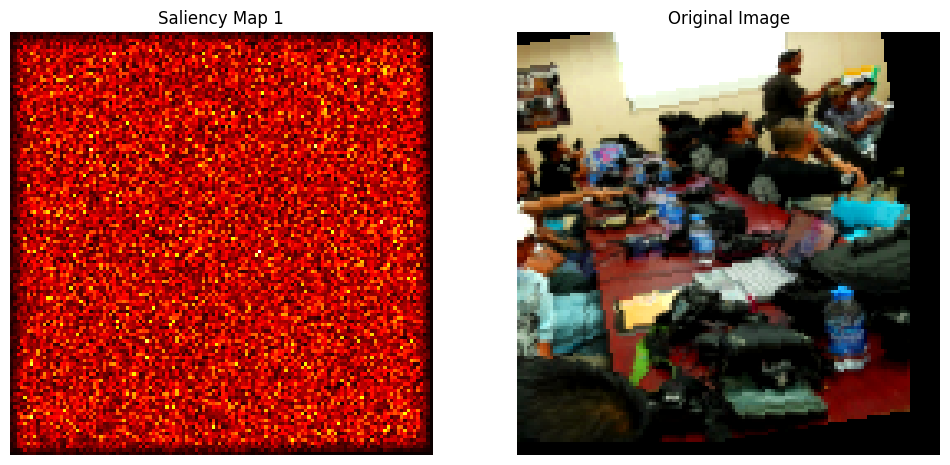

In [34]:


X = next(iter(train_loader))[0].to(device)
X = next(iter(train_loader))[0].to(device)
X = X[0].to(device) #get single shape
model = Network04()

# we would run the model in evaluation mode
model.to(device)

for param in model.parameters():
    param.requires_grad = False
model.eval()

X = X.unsqueeze(0)
# print(X.shape)
# print(X)
# print(X.shape)
X.requires_grad = True


scores = model(X)
print(scores)

# # Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]
print(score_max)

score_max.backward()

#ChatGPT coded some of this
saliency, _ = torch.max(X.grad.data.abs(),dim=1)
saliency = saliency.to('cpu')



fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first saliency map on the first subplot
axes[0].imshow(saliency[0], cmap=plt.cm.hot)
axes[0].axis('off')  # Hide the axis on the first subplot
axes[0].set_title('Saliency Map 1')  # Optional: Set a title for the first subplot

X = X.squeeze(0)
X = X.to('cpu')
# Plot the second saliency map on the second subplot
axes[1].imshow(np.swapaxes(np.swapaxes(X.detach().numpy(), 0, 2), 0, 1))
axes[1].axis('off')  # Hide the axis on the second subplot
axes[1].set_title('Original Image')  # Optional: Set a title for the second subplot

# Display the figure with both subplots
plt.show()

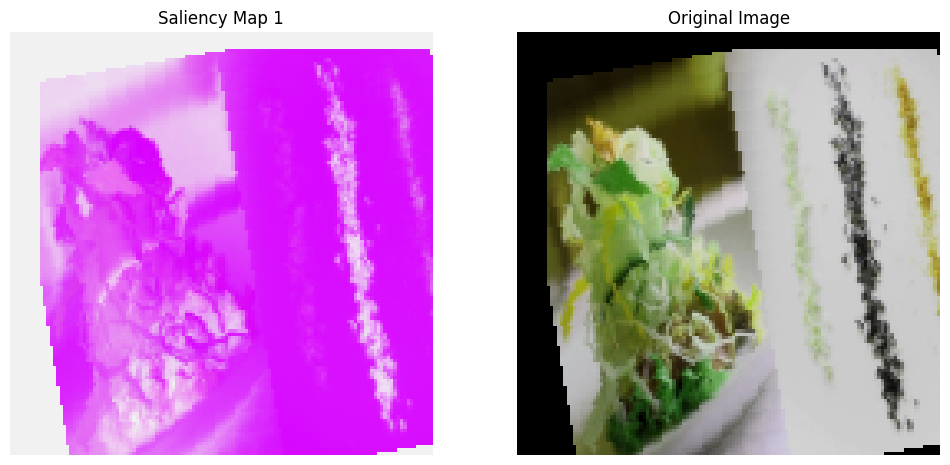

In [92]:
# Initialize the model
model = Network04()
model.eval()
model.to(device)

# Adjust single input and target to match each other
input_image, target = next(iter(train_loader))
input_image = input_image[0].unsqueeze(0).to(device)
# input_image = input_image.
input_image.requires_grad = True

output = model(input_image)

#Match target dtype and shape to output
target = target[0].view(-1,1)
target = target.float().view_as(output) #Target shape will match output shape
target = target.to(device)

# Calculate Loss and find input gradient by backpropagation
output_sig = torch.sigmoid(output)
loss = F.binary_cross_entropy(output_sig, target)
model.zero_grad()
loss.backward()

# Setup for display
gradient = input_image.grad.data

# Pool the gradients across the channels
pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])


# A try at making a saliency map
saliency = torch.zeros_like(input_image).to(device)
for i in range(3):
    saliency[0, i, ...] = input_image[0, i, ...] * pooled_gradients[i]

#Normalize the saliency map
saliency_max = saliency.max()
saliency_min = saliency.min()

if saliency_max != saliency_min:
    saliency_normalized = (saliency - saliency_min) / (saliency_max - saliency_min)
else:
    saliency_normalized = saliency


saliency = saliency_normalized.to('cpu')
saliency_map = torch.abs(saliency).squeeze()
image = input_image.squeeze(0).to('cpu')


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the saliency map
axes[0].imshow(saliency_map.permute(1, 2, 0).detach().numpy())
axes[0].set_title('Saliency Map 1')  
axes[0].axis('off')


#Plot Image
axes[1].imshow(np.swapaxes(np.swapaxes(image.detach().numpy(), 0, 2), 0, 1))
axes[1].axis('off')  # Hide the axis on the second subplot
axes[1].set_title('Original Image')  

plt.show()

<h1>Transfer Learning: Resnet50 with default weights</h1>

In [89]:
#she is there
#MARTIN IS PLAYING
import torch.optim as optim
import torchvision.models as models

optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = optimizer_adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=1e-5, patience=50, factor=0.1)


model = models.resnet50(pretrained=True)
#We don't need to fix the first layer, becuase it also expects 3 channels.
num_ftrs = model.fc.in_features 
model.fc = nn.Linear(num_ftrs, 1)  # Replace the final layer
model.to(device)

num_epochs = 5
loss_function = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()  
    train_correct = 0 
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output.squeeze(), target.float())  
        loss.backward()
        optimizer.step()
        
        predicted = (output > 0).float()  # Connverts logits to 0s and 1s
        train_correct += (target == predicted.squeeze()).sum().item()

    model.eval()  # Set the model to evaluation mode
    val_correct = 0
    with torch.no_grad():
        for data, target in  val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output.squeeze(), target.float())  

            optimizer.step()
            # scheduler.step(loss)
            predicted = (output > 0).float()  # Convert logits to 0s and 1s
            val_correct += (target == predicted.squeeze()).sum().item()
            

    train_acc = train_correct / len(trainset)
    val_acc = val_correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, val Accuracy: {val_acc*100:.1f}%")

 
test_correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        predicted = (output > 0).float()  # Convert logits to 0s and 1s
        test_correct += (target == predicted.squeeze()).sum().item()

 
test_acc = test_correct / len(testset)
print(f"Epoch {epoch+1}/{num_epochs}, Test Accuracy: {test_acc*100:.1f}%")


 

/zhome/25/e/155273/Desktop/02516_dvcv/02516_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/zhome/25/e/155273/Desktop/02516_dvcv/02516_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/5, Train Accuracy: 47.0%, val Accuracy: 50.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2/5, Train Accuracy: 46.1%, val Accuracy: 44.6%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3/5, Train Accuracy: 44.9%, val Accuracy: 46.9%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4/5, Train Accuracy: 46.7%, val Accuracy: 44.1%


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5/5, Train Accuracy: 47.8%, val Accuracy: 47.2%
Epoch 5/5, Test Accuracy: 47.5%


<h1>Transfer Learning Saliency Map </h1>

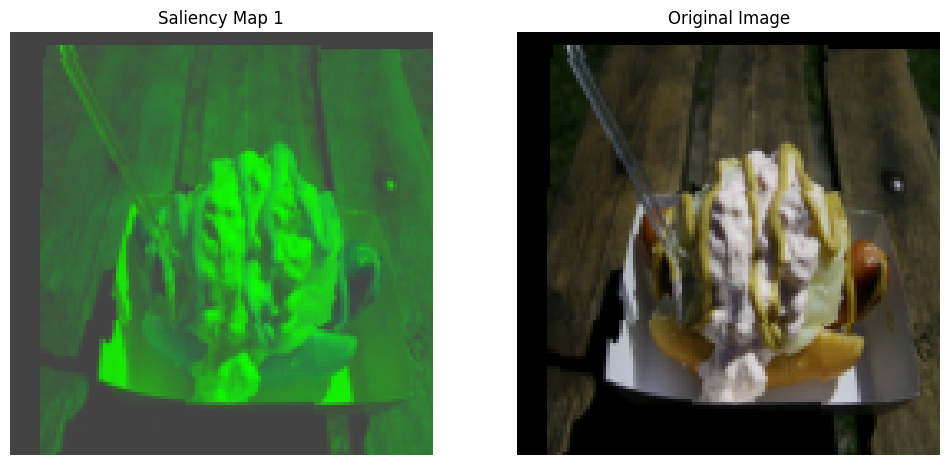

In [74]:
#I just realized this is regarded because the resnet obviously does not h ave a class for hotdogs.. FUCK
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models

#Use this if you wanna test the model without training for hotdogs first, also make sure resnet50 isn't saved.
# model = models.resnet50(pretrained=True)
# num_ftrs = model.fc.in_features 
# model.fc = nn.Linear(num_ftrs, 1)  # Replace the final layer

model.eval()
model.to(device)

image, target = next(iter(train_loader))
image = image[0].unsqueeze(0).to(device)
image.requires_grad = True


output = model(image)
model.zero_grad()

target = target[0].view(-1,1)
target = target.float().view_as(output) 
target = target.to(device)


loss = F.binary_cross_entropy_with_logits(output, target)
loss.backward()


# Pull the gradients out of the model
gradients = image.grad.data

# Pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])


# Apply the gradients to the image to create a saliency map
saliency = torch.zeros_like(image).to(device)
for i in range(3):
    saliency[0, i, ...] = image[0, i, ...] * pooled_gradients[i]

#Normalize the saliency map
saliency_max = saliency.max()
saliency_min = saliency.min()

if saliency_max != saliency_min:
    saliency_normalized = (saliency - saliency_min) / (saliency_max - saliency_min)
else:
    saliency_normalized = saliency

# Setup for displaying
saliency = saliency_normalized.to('cpu')
saliency_map = torch.abs(saliency).squeeze()
image = image.to('cpu')

image = image.squeeze(0)
image = image.to('cpu')


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the saliency map
axes[0].imshow(saliency_map.permute(1, 2, 0).detach().numpy())
axes[0].set_title('Saliency Map 1')  
axes[0].axis('off')


#Plot Image
axes[1].imshow(np.swapaxes(np.swapaxes(image.detach().numpy(), 0, 2), 0, 1))
axes[1].axis('off')  # Hide the axis on the second subplot
axes[1].set_title('Original Image')  

plt.show()
